In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from pandas import datetime
import tensorflow as tf
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
sns.set()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, MinMaxScaler

In [2]:

sys.path.append(os.path.abspath(os.path.join("../scripts/")))
warnings.filterwarnings("ignore")
from preprocessing import Preprocessor
from ltsm import TimeSeriesSalsesPred


In [6]:
import dvc.api

with dvc.api.open(
    "data/merged_train.csv",
    # repo="https://github.com/abeselomg/-pharmaceutical-sales-prediction",
) as f:
    train_df = pd.read_csv(f)


In [7]:
prepro = Preprocessor(train_df)

clean_train_data = prepro.return_clean_data()


### 1. Isolate the Rossmann Store Sales dataset into time series data

In [9]:

sales_series = clean_train_data[["Date", "Sales"]].sort_values(by="Date")

data_agg = sales_series.groupby("Date").agg({"Sales": "mean"})


### 2. Check whether your time Series Data is Stationary

<AxesSubplot:xlabel='Date'>

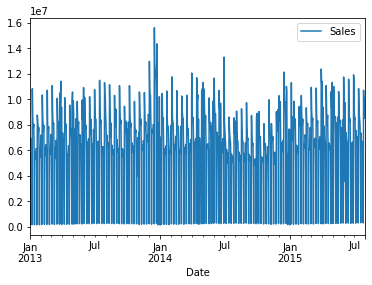

In [10]:
sales_series.groupby("Date").sum().plot()


In [12]:
data_agg

Index(['Sales'], dtype='object')

<h3 style='font-style:italic'> Observation: Since we can observe seasonality on the graph, the data is not stationary.</h3>

### 3. Depending on your conclusion from 2 above difference your time series data

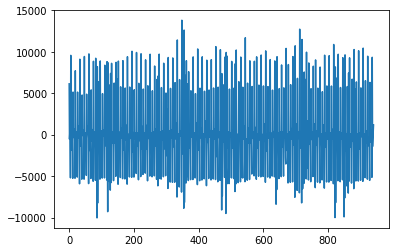

In [14]:
# performing difference transform (first order differencing)
df_agg_to_series = data_agg.copy()

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
 

X = df_agg_to_series.values
diff = difference(X)
plt.plot(diff)
plt.show()

### 4. Check for autocorrelation and partial autocorrelation of your data

#### Autocorrelation

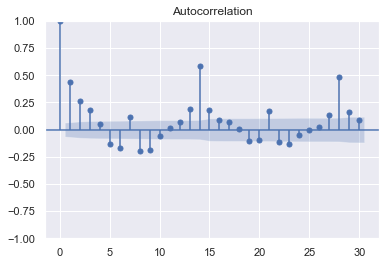

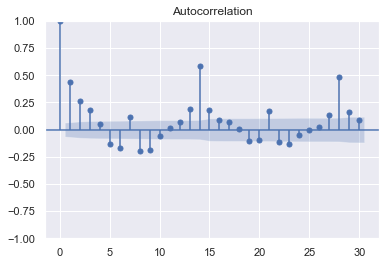

In [10]:
plot_acf(data_agg)

#### Partial Autocorrelation

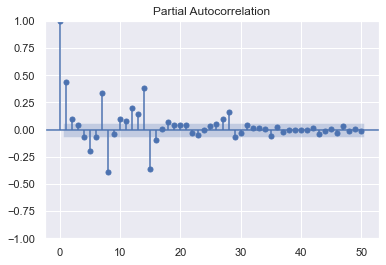

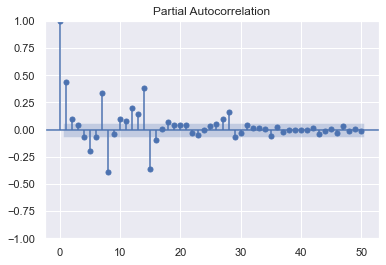

In [11]:
plot_pacf(data_agg, lags=50)

### 5. Transform the time series data into supervised learning data by creating a new y(target) column.

In [15]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Sales%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Sales%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Sales%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
    
diff_new  = diff.copy()
supervised_data = series_to_supervised(diff)
supervised_data['Sales'] = supervised_data['Sales1(t-1)']
supervised_data.drop(columns=['Sales1(t-1)'], inplace=True)
first_column = supervised_data.pop('Sales')
  
supervised_data.insert(0, 'Sales', first_column)
supervised_data.head()

,Sales,Sales1(t)
1,[6145.745933129916],[-539.9183856502241]
2,[-539.9183856502241],[261.1067264573994]
3,[261.1067264573994],[-616.4672645739911]
4,[-616.4672645739911],[-5208.689686098655]
5,[-5208.689686098655],[9581.115695067265]


### 6. Scale your data in the (-1, 1) range

In [17]:
nd = supervised_data.to_numpy()

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_data = scaler.fit_transform(nd)
scaled_df = pd.DataFrame(scaled_data, columns=supervised_data.columns)
scaled_df

,Sales,Sales1(t)
0,0.678472,0.398370
1,0.398370,0.431930
2,0.431930,0.395163
3,0.395163,0.202768
4,0.202768,0.822400
...,...,...
935,0.205469,0.812574
936,0.812574,0.361163
937,0.361163,0.397878
938,0.397878,0.432221


### 7. Build a LSTM Regression model to predict the next sale

In [14]:
SIZE = len(scaled_df["Sales"])
# SIZE = len(data_agg["Sales"])

WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 100 
pred = TimeSeriesSalsesPred(WINDOW_SIZE, BATCH_SIZE, scaled_df)

print(SIZE)
print(BATCH_SIZE)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

940
844


2022-05-28 13:04:38.038079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-28 13:04:38.038188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022/05/28 13:04:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-05-28 13:04:38.526249: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-28 13:04:40.087333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:40.339816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:40.441260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:40.563042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:40.707254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 2s 2s/step - loss: 0.0750

2022-05-28 13:04:41.094144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:41.162959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:41.217770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 0.0750 - val_loss: 0.0603
Epoch 2/100
1/1 [==============================] - 0s 104ms/step - loss: 0.0693 - val_loss: 0.0526
Epoch 3/100
1/1 [==============================] - 0s 92ms/step - loss: 0.0638 - val_loss: 0.0455
Epoch 4/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0585 - val_loss: 0.0389
Epoch 5/100
1/1 [==============================] - 0s 92ms/step - loss: 0.0535 - val_loss: 0.0328
Epoch 6/100
1/1 [==============================] - 0s 110ms/step - loss: 0.0488 - val_loss: 0.0272
Epoch 7/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0442 - val_loss: 0.0222
Epoch 8/100
1/1 [==============================] - 0s 103ms/step - loss: 0.0400 - val_loss: 0.0178
Epoch 9/100
1/1 [==============================] - 0s 98ms/step - loss: 0.0360 - val_loss: 0.0141
Epoch 10/100
1/1 [==============================] - 0s 109ms/step - loss: 0.0322 - val_loss: 0.0112
Epoch 11/100
1/1 [=========

2022/05/28 13:04:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'PrefetchDataset' object has no attribute '_batch_size'


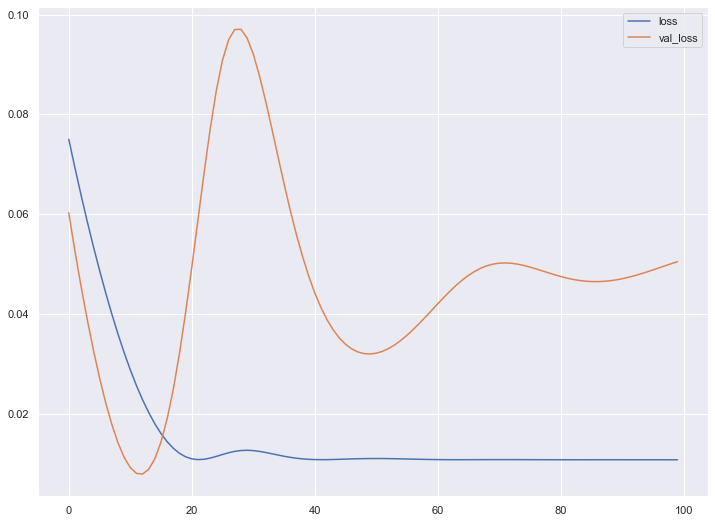

In [15]:
model1, his = pred.train(EPOCHS)

2022-05-28 13:04:52.630772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:52.740567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-28 13:04:52.800807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 514ms/step


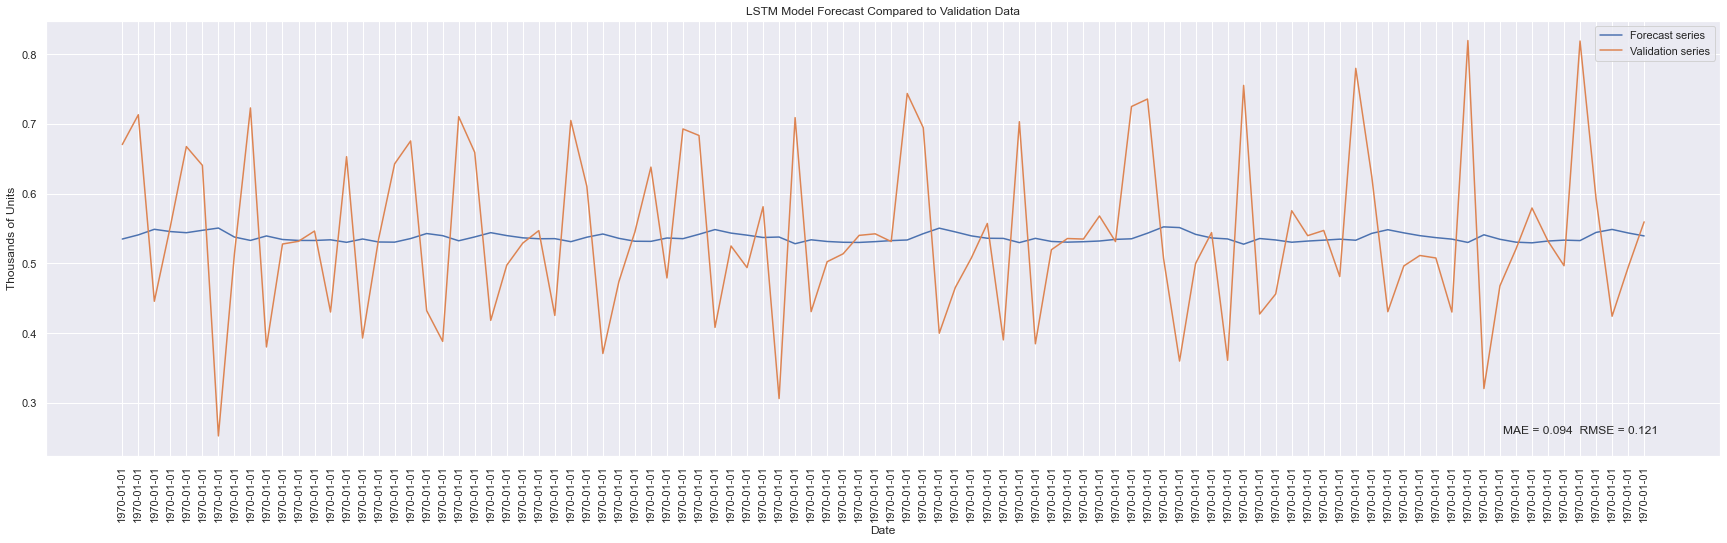

In [16]:
forecast, fig, MAE, RMSE = pred.model_forecast_test(model1)


#### Forcast the sales for the next 6 weeks

In [33]:

def forcast_next_one_sale(model, sales):
    data_feat = None
    WINDOW_SIZE = 49
    try:
        data_feat = sales[["Sales", "Date"]]
        
        if (data_feat.shape[0] < 49):
            print("To make prediction, we need atleast data of 49 dates")
            return
        scaled_dff, scaler_obj = lp.LstmPrediction(WINDOW_SIZE, BATCH_SIZE, scaled_df).add_scaled_sales(data_feat)
        data_feat["Sales"].isna().any().sum()
        SIZE = len(data_agg["Sales"])
        
        
        series = scaled_dff["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
        ds = ds.batch(SIZE).prefetch(1)
        
        forecast = model.predict(ds)
        Results = list(forecast.reshape(1, forecast.shape[0] * forecast.shape[1])[0].copy())

        Results1 = scaler_obj.inverse_transform(forecast.reshape(-1,1))
        Results1 = list(Results1.reshape(1, Results1.shape[0] * Results1.shape[1])[0])
        
        return  Results1, Results
        
    except KeyError as e:
        print(e)
        return False

In [34]:
def forcast_next_sales(model, sales, daysToForcast=1):
    forcasts = []
    scaled_forcasts = []
    dates = []
    
    new_sales_df = sales.copy()
    while len(forcasts) < daysToForcast:
        forcast, scaled_forcast = forcast_next_one_sale(model, new_sales_df)
        forcasts += forcast
        
        scaled_forcasts += scaled_forcast
        size=len(new_sales_df["Sales"])
        
        truncated_sales = new_sales_df.tail(size - len(scaled_forcast))
                
        new_sales = truncated_sales['Sales'].to_list() + scaled_forcast
        next_dates = []
        
        for i in range(len(scaled_forcast)):
            next_date = new_sales_df["Date"].to_list()[-1] + timedelta(days=1)
            next_dates.append(next_date)     
        
        new_dates = truncated_sales['Date'].to_list() + next_dates
        new_sales_df = pd.DataFrame()
        new_sales_df["Date"] = new_dates
        new_sales_df["Sales"] = new_sales
    
    res_df = pd.DataFrame()
    res_df["Date"] = new_dates
    res_df["forcasts"] = forcasts
    
    return res_df

In [35]:
# data_agg[["Sales", "Date"]].head()

In [36]:
scaled_df["Date"] = scaled_df.index
scaled_df["Date"] = scaled_df["Date"].astype("datetime64[ns]")
res_df = forcast_next_sales(model1, scaled_df.head(49), 49)
res_df

1/1 [==============================] - 0s 27ms/step


,Date,forcasts
0,1970-01-02 00:00:00.000000048,0.746619
1,1970-01-03 00:00:00.000000048,0.756161
2,1970-01-04 00:00:00.000000048,0.769778
3,1970-01-05 00:00:00.000000048,0.789436
4,1970-01-06 00:00:00.000000048,0.815733
5,1970-01-07 00:00:00.000000048,0.839748
6,1970-01-08 00:00:00.000000048,0.865111
7,1970-01-09 00:00:00.000000048,0.888466
8,1970-01-10 00:00:00.000000048,0.911094
9,1970-01-11 00:00:00.000000048,0.931935


In [45]:
sk_path_dir_2 = mlflow.sklearn.save_model(model1, "../models/lstm_model",
                          serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

INFO:tensorflow:Assets written to: ram://9b996260-8706-4831-9fdf-ca285dff0220/assets


INFO:tensorflow:Assets written to: ram://9b996260-8706-4831-9fdf-ca285dff0220/assets
